In [1]:
import pickle
from string import punctuation

import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# Load the data
import logging
logger = logging.getLogger("spacy")
logger.setLevel(logging.ERROR)

import dask.bag as db
import json

docs = db.read_text('../Data/arxiv-metadata-oai-snapshot.json').map(json.loads)

In [209]:
# Trimming the data
get_latest_version = lambda x: x['versions'][-1]['created']


# get only necessary fields of the metadata file
trim = lambda x: {'id': x['id'],
                  'authors': x['authors'],
                  'title': x['title'],
                  'versions': x['versions'],
                  'category':x['categories'].split(' '),
                  'abstract':x['abstract'],}

# filter for papers published on or after 2019-01-01
columns = ['id','category','abstract','versions']
docs_df = docs.map(trim).compute()

# convert to pandas
docs_df = pd.DataFrame(docs_df)

In [210]:
#save trimmed dataset for later use so we can skip the dataset trimming later:
docs_df.to_csv("../Data/trimmed_arxiv_docs2.csv", index=False)

In [212]:
# Read docs from the file
docs_df = pd.read_csv('../Data/trimmed_arxiv_docs2.csv')

/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [213]:
# Listing categories
categories = list(docs_df['category'].unique())
        

In [214]:
# Split categories
def splitCategory(cat):
    tmp = cat.replace('[','').replace(']','')
    c = tmp.split(', ')
    c = [w.replace("'","") for w in c]
    return c

In [215]:
# Find main category
def findMainCat(categories):
    new_cat = list(dict.fromkeys([cat.split(".")[0] for cat in categories]))
    return new_cat


Cleaning the data

In [216]:
df = pd.read_csv("../Data/trimmed_arxiv_docs2.csv")

In [217]:
# Adding abstract word count
df['abstract_word_count'] = docs_df['abstract'].apply(lambda x: len(x.strip().split())) 

In [218]:
df['abstract'].describe(include='all')

count                                1967621
unique                               1965958
top         This paper has been withdrawn.\n
freq                                      91
Name: abstract, dtype: object

In [219]:
# Getting rid of duplicates
df.drop_duplicates(['abstract',], inplace=True)
df['abstract'].describe(include='all')

count                                               1965958
unique                                              1965958
top         We study the problem of estimating multivari...
freq                                                      1
Name: abstract, dtype: object

NLP data processing

In [220]:
# Add the categories
df['list_categories'] = df.category.apply(splitCategory)
df['main_categories'] = df.list_categories.apply(findMainCat)

In [221]:
# Create CS and Random dataframes
bool_series = ["cs" in cat for cat in df.main_categories]
df_cs = df[bool_series]

In [222]:
# Non-CS df
bool_series = ["cs" not in cat for cat in df.main_categories]
df_random = df[bool_series]

In [223]:
# Reduce the size of the data
df_cs = df_cs.sample(10000, random_state=42)
df_random = df_random.sample(10000, random_state=42)

In [248]:
def get_year(version):
    return version.split(': ')[2].split(' ')[3]

In [249]:
df_cs['year'] = df_cs.versions.apply(get_year)
df_random['year'] = df_random.versions.apply(get_year)

In [253]:
print(sorted(set(df_cs.year)))

['1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']


In [254]:
#Define stopwords (scientific stopwords)
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
stopwords = STOP_WORDS

In [255]:
#Define the cleaner - remove punctuation and stopwords
def cleanPunct(text):
    return [w for w in text if w not in punctuation]

In [256]:
# make everything lowercase
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
def low(instance):
    tokens = word_tokenize(instance)
    return [w.lower() for w in tokens if w not in ["(", ")"]]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/miamijovic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [257]:
# Create column with lowercase text
df_cs['cleaned'] = df_cs.abstract.apply(low)
df_random['cleaned'] = df_random.abstract.apply(low)


In [258]:
# Make ngrams
from nltk.util import ngrams

def bigrams(arr):
    return list(ngrams(arr, 2))

def trigrams(arr):
    return list(ngrams(arr,3))

In [259]:
#apply cleaning punctiation on unigrams
df_cs['cleaned'] = df_cs.cleaned.apply(cleanPunct)
df_random['cleaned'] = df_random.cleaned.apply(cleanPunct)
# Creating ngrams
df_cs['bigrams'] = df_cs.cleaned.apply(bigrams)
df_random['bigrams'] = df_random.cleaned.apply(bigrams)
df_cs['trigrams'] = df_cs.cleaned.apply(trigrams)
df_random['trigrams'] = df_random.cleaned.apply(trigrams)


In [260]:
def hyphenate(words, n):
    if(n==2):
        return [w[0]+'-'+w[1] for w in words]
    if(n==3):
        return [w[0]+'-'+w[1]+'-'+w[2] for w in words]

Dictionaties and most frequent term analysis

In [261]:
# Create dict func
def createDict(data):
    vocab = {}
    for instance in data:
        d = Counter(instance)
        for w in d.keys():
            if w in vocab:
                vocab[w] += d[w]
            else:
                vocab[w] = d[w]
    return dict(sorted(vocab.items(), key=lambda item: item[1], reverse=True))

In [262]:
from collections import Counter
unigram_cs = createDict(df_cs['cleaned'])
bigram_cs = createDict(df_cs['bigrams'])
trigram_cs = createDict(df_cs['trigrams'])

unigram_rand = createDict(df_random['cleaned'])
bigram_rand = createDict(df_random['bigrams'])
trigram_rand = createDict(df_random['trigrams'])

In [263]:
print(len(trigram_cs))

1166877


In [264]:
# Removing stopwords and punctuation
def clean(text):
    return [w for w in text if w not in punctuation and w not in stopwords]

In [265]:
df_cs['cleaned'] = df_cs.cleaned.apply(clean)
df_random['cleaned'] = df_random.cleaned.apply(clean)
df_cs['bigrams'] = df_cs.cleaned.apply(bigrams)
df_random['bigrams'] = df_random.cleaned.apply(bigrams)
df_cs['trigrams'] = df_cs.cleaned.apply(trigrams)
df_random['trigrams'] = df_random.cleaned.apply(trigrams)

In [270]:
unigram_cs = createDict(df_cs['cleaned'])
bigram_cs = createDict(df_cs['bigrams'])
trigram_cs = createDict(df_cs['trigrams'])

unigram_rand = createDict(df_random['cleaned'])
bigram_rand = createDict(df_random['bigrams'])
trigram_rand = createDict(df_random['trigrams'])

In [271]:
# Trim ngrams 
def trim(d, num):
    return dict((k, v) for k, v in d.items() if v>=num)

In [272]:
trim_value = 4
unigram_cs = trim(unigram_cs, trim_value)
unigram_rand = trim(unigram_rand, trim_value)
bigram_cs = trim(bigram_cs, trim_value)
bigram_rand = trim(bigram_rand, trim_value)
trigram_cs = trim(trigram_cs, trim_value)
trigram_rand = trim(trigram_rand, trim_value)

In [273]:
print(len(trigram_rand))

1835


In [274]:
df_cs

,id,authors,title,versions,category,abstract,abstract_word_count,list_categories,main_categories,year,cleaned,bigrams,trigrams
948505,1802.08965,"Hamid G. Bafghi, Amin Gohari, Mahtab Mirmohsen...",Diffusion Based Molecular Communication with L...,"[{'version': 'v1', 'created': 'Sun, 25 Feb 201...","['cs.IT', 'math.IT']",This paper studies the impact of a transmitt...,160,"[cs.IT, math.IT]","[cs, math]",2018,"[paper, studies, impact, transmitter, molecule...","[(paper, studies), (studies, impact), (impact,...","[(paper, studies, impact), (studies, impact, t..."
1497027,2107.03015,Juan Jose Garau-Luis and Edward Crawley and Br...,Evaluating the progress of Deep Reinforcement ...,"[{'version': 'v1', 'created': 'Wed, 7 Jul 2021...","['cs.LG', 'cs.AI']",Deep Reinforcement Learning (DRL) is conside...,128,"[cs.LG, cs.AI]",[cs],2021,"[deep, reinforcement, learning, drl, considere...","[(deep, reinforcement), (reinforcement, learni...","[(deep, reinforcement, learning), (reinforceme..."
1040347,1810.0916,"Peter Snyder, Antoine Vastel, Benjamin Livshits",Who Filters the Filters: Understanding the Gro...,"[{'version': 'v1', 'created': 'Mon, 22 Oct 201...",['cs.CR'],Ad and tracking blocking extensions are popu...,275,[cs.CR],[cs],2018,"[ad, tracking, blocking, extensions, popular, ...","[(ad, tracking), (tracking, blocking), (blocki...","[(ad, tracking, blocking), (tracking, blocking..."
1189193,1910.05274,"Jan H\k{a}z{\l}a, Yan Jin, Elchanan Mossel, Go...",A Geometric Model of Opinion Polarization,"[{'version': 'v1', 'created': 'Fri, 11 Oct 201...","['cs.SI', 'econ.TH']","We introduce a simple, geometric model of op...",103,"[cs.SI, econ.TH]","[cs, econ]",2019,"[introduce, simple, geometric, model, opinion,...","[(introduce, simple), (simple, geometric), (ge...","[(introduce, simple, geometric), (simple, geom..."
1336457,2008.08735,"Shuangjun Liu, Xiaofei Huang, Nihang Fu, Cheng...",Simultaneously-Collected Multimodal Lying Pose...,"[{'version': 'v1', 'created': 'Thu, 20 Aug 202...",['cs.CV'],Computer vision (CV) has achieved great succ...,198,[cs.CV],[cs],2020,"[computer, vision, cv, achieved, great, succes...","[(computer, vision), (vision, cv), (cv, achiev...","[(computer, vision, cv), (vision, cv, achieved..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271156,2004.06386,Roman Matzutt and Jan Pennekamp and Erik Buchh...,Utilizing Public Blockchains for the Sybil-Res...,"[{'version': 'v1', 'created': 'Tue, 14 Apr 202...","['cs.CR', 'cs.NI']","Distributed anonymity services, such as onio...",160,"[cs.CR, cs.NI]",[cs],2020,"[distributed, anonymity, services, onion, rout...","[(distributed, anonymity), (anonymity, service...","[(distributed, anonymity, services), (anonymit..."
524647,1405.3739,"Erik Demaine, Nathan Pinsker, and Jon Schneider",Fast Dynamic Pointer Following via Link-Cut Trees,"[{'version': 'v1', 'created': 'Thu, 15 May 201...",['cs.DS'],"In this paper, we study the problem of fast ...",76,[cs.DS],[cs],2014,"[paper, study, problem, fast, dynamic, pointer...","[(paper, study), (study, problem), (problem, f...","[(paper, study, problem), (study, problem, fas..."
90388,810.4809,"T. Grust, M. Mayr, J. Rittinger",XQuery Join Graph Isolation,"[{'version': 'v1', 'created': 'Mon, 27 Oct 200...",['cs.DB'],A purely relational account of the true XQue...,133,[cs.DB],[cs],2008,"[purely, relational, account, true, xquery, se...","[(purely, relational), (relational, account), ...","[(purely, relational, account), (relational, a..."
620353,1505.00081,"Lingxiao Huang, Jian Li, Qicai Shi",Approximation Algorithms for the Connected Sen...,"[{'version': 'v1', 'created': 'Fri, 1 May 2015...",['cs.DS'],We study the minimum connected sensor cover ...,150,[cs.DS],[cs],2015,"[study, minimum, connected, sensor, cover, pro...","[(study, minimum), (minimum, connected), (conn...","[(study, minimum, connected), (minimum, connec..."


In [275]:
# Filter out dataframe, leave only ngrams from the list + hyphenate
def filterOutUniCs(words):
    return [w for w in words if w in unigram_cs]
def filterOutBiCs(words):
    return [w[0]+'-'+w[1] for w in words if w in bigram_cs]
def filterOutTriCs(words):
    return [w[0]+'-'+w[1]+'-'+w[2] for w in words if w in trigram_cs]
def filterOutUniRand(words):
    return [w for w in words if w in unigram_rand]
def filterOutBiRand(words):
    return [w[0]+'-'+w[1] for w in words if w in bigram_rand]
def filterOutTriRand(words):
    return [w[0]+'-'+w[1]+'-'+w[2] for w in words if w in trigram_rand]

In [276]:
df_cs.cleaned = df_cs.cleaned.apply(filterOutUniCs)
df_cs.bigrams = df_cs.bigrams.apply(filterOutBiCs)
df_cs.trigrams = df_cs.trigrams.apply(filterOutTriCs)

df_random.cleaned = df_random.cleaned.apply(filterOutUniRand)
df_random.bigrams = df_random.bigrams.apply(filterOutBiRand)
df_random.trigrams = df_random.trigrams.apply(filterOutTriRand)

Feature Selection on CS vs Random

In [277]:
#CHI-Square stastic where:
# a - number of times t and c co-occur 11
# b - number of times t occurs w/o c 10
# c - number of times c occurs w/o t 01
# d - number of times neither c nor t occur 00
def chi_square(n,a,b,c,d):
    return n*((a*d-c*b)**2)/((a+c)*(b+d)*(a+b)*(c+d))

In [278]:
def selectKbest(features, k):
    features = {a: v for a, v in sorted(features.items(), key=lambda item: item[1], reverse=True)}
    features = {a: features[a] for a in list(features)[:k]}
    return features

In [279]:
def findOccurrences(term, C, notC):
    a = 0
    b = 0
    c = 0
    d = 0
    for item in C:
        if term in item:
            a += 1
        else:
            c += 1
    for item in notC:
        if term in item:
            b += 1
        else:
            d += 1
    return a,b,c,d


In [280]:
# Calculate chi2 values for each word
from collections import Counter

def createTermLists(cat, nonCat):
    # Find number of times term and class co-occur
    wordsC = Counter()
    for items in cat:
        wordsC = wordsC + Counter(items)
    return wordsC


In [281]:
def findChiValues(cat, nonCat):
    wordsC = createTermLists(cat, nonCat)
    chi_values = {}
    for term in wordsC:
        a,b,c,d = findOccurrences(term, cat, nonCat)
        n = len(cat) + len(nonCat)
        chi_values[term] = chi_square(n, a, b, c, d)
    return chi_values

In [282]:
chi_values_uni = findChiValues(df_cs.cleaned, df_random.cleaned)

In [283]:
print(len(chi_values_uni))

15382


In [284]:
chi_values_bi = findChiValues(df_cs.bigrams, df_random.bigrams)
chi_values_tri = findChiValues(df_cs.trigrams, df_random.trigrams)

In [285]:
# Filter by chi value chiVal
def selectChiBest(features, chiVal):
    features = {a: v for a, v in sorted(features.items(), key=lambda item: item[1], reverse=True)}
    features = {a: features[a] for a in features if features[a]>chiVal}
    return features

In [286]:
chiVal = 40
chi_best_uni = selectChiBest(chi_values_uni, chiVal)
chi_best_bi = selectChiBest(chi_values_bi, chiVal)
chi_best_tri = selectChiBest(chi_values_tri, chiVal)

print(chi_best_tri)

{'deep-neural-networks': 185.70851836899476, 'convolutional-neural-networks': 183.67140982944798, 'convolutional-neural-network': 151.13350125944584, 'paper-propose-novel': 124.77359629704166, 'deep-neural-network': 99.49248781468268, 'natural-language-processing': 96.46302250803859, 'experimental-results-demonstrate': 77.29759574361292, 'neural-networks-cnns': 76.28990162617949, 'machine-learning-models': 63.19907709284245, 'deep-reinforcement-learning': 62.19279767278564, 'paper-propose-new': 62.19279767278564, 'deep-learning-models': 62.19279767278564, 'channel-state-information': 61.186619188525, 'code-available-https': 60.18054162487462, 'deep-convolutional-neural': 56.15724027276374, 'recurrent-neural-network': 55.15166708448233, 'generative-adversarial-networks': 55.15166708448233, 'neural-network-cnn': 53.14082318143079, 'recurrent-neural-networks': 53.14082318143079, 'internet-things-iot': 49.12034484486993, 'neural-networks-dnns': 47.11071016889691, 'generative-adversarial-ne

In [287]:
import json
chi_vals = [chi_best_uni, chi_best_bi, chi_best_tri]
with open('chi_data.json', 'w') as f:
    json.dump(chi_vals, f)

In [288]:
# Make unified df
df_combined = df_cs[['abstract', 'list_categories', 'main_categories', 'year']].copy()
df_tmp = df_random[['abstract', 'list_categories', 'main_categories', 'year']].copy()
df_combined = df_combined.append(df_tmp)

df_combined

,abstract,list_categories,main_categories,year
948505,This paper studies the impact of a transmitt...,"[cs.IT, math.IT]","[cs, math]",2018
1497027,Deep Reinforcement Learning (DRL) is conside...,"[cs.LG, cs.AI]",[cs],2021
1040347,Ad and tracking blocking extensions are popu...,[cs.CR],[cs],2018
1189193,"We introduce a simple, geometric model of op...","[cs.SI, econ.TH]","[cs, econ]",2019
1336457,Computer vision (CV) has achieved great succ...,[cs.CV],[cs],2020
...,...,...,...,...
1822458,We use the exact instanton expansion to illu...,[hep-th],[hep-th],2004
1929984,The serious study of such science fiction st...,"[physics.space-ph, physics.pop-ph]",[physics],2002
1891142,We apply the Euler--Maclaurin formula to fin...,"[math.CO, math.NT]",[math],2006
1936483,It is shown that the presence of mixed-cultu...,[physics.bio-ph],[physics],2005


In [289]:
# Filter
def filterAbstract(text, chi_best_bi, chi_best_tri):
    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens if w not in punctuation]
    # Find trigrams
    i = 0
    new1 = []
    while(i<len(tokens)-2):
        trigram = tokens[i]+'-'+tokens[i+1]+'-'+tokens[i+2]
        if(trigram in chi_best_tri):
            new1.append(trigram)
            i += 3
        else:
            new1.append(tokens[i])
            i += 1
    
    #Find bigrams
    i = 0
    new2 = []
    while(i<len(new1)-1):
        bigram = new1[i]+'-'+new1[i+1]
        if(bigram in chi_best_bi):
            new2.append(bigram)
            i += 2
        else:
            new2.append(new1[i])
            i += 1

    return new2


In [291]:
df_combined['filteredAbstracts'] = df_combined.abstract.apply(filterAbstract, chi_best_bi = chi_best_bi, chi_best_tri = chi_best_tri)

In [292]:
print(list(df_combined.filteredAbstracts.head(3)))

[['this', 'paper', 'studies', 'the', 'impact', 'of', 'a', 'transmitter', "'s", 'molecule', 'generation', 'process', 'on', 'the', 'capacity', 'of', 'a', 'concentration', 'based', 'molecular', 'communication', 'mc', 'system', 'constraints', 'caused', 'by', 'the', 'molecule', 'generation', 'process', 'affect', 'the', 'availability', 'of', 'the', 'molecules', 'at', 'the', 'transmitter', 'the', 'transmitter', 'has', 'a', 'storage', 'of', 'molecules', 'and', 'should', 'decide', 'whether', 'to', 'release', 'or', 'save', 'the', 'currently', 'produced', 'molecules', 'as', 'a', 'result', 'the', 'mc', 'system', 'has', 'conceptual', 'connections', 'with', 'energy', 'harvesting', 'systems', 'in', 'this', 'paper', 'we', 'consider', 'two', 'scenarios', 'on', 'the', 'propagation', 'channel', 'the', 'first', 'scenario', 'assumes', 'a', 'channel', 'with', 'no', 'inter-symbol', 'interference', 'isi', '\\emph', 'i.e.', 'a', 'memoryless', 'channel', 'we', 'derive', 'bounds', 'on', 'the', 'capacity', 'of', 

In [293]:
def filterAdvance(text):
    return [w for w in text if (w in chi_best_uni or w in chi_best_bi or w in chi_best_tri) and w in dictCombined and len(w)>1]

In [294]:
# Remove stop words
df_combined['filteredAbstracts'] = df_combined.filteredAbstracts.apply(clean)

In [ ]:
dictCombined = createDict(df_combined['filteredAbstracts'])
trim_value = 5
dictCombined = trim(dictCombined, trim_value)
print(dictCombined)

In [296]:
# Filter out unigrams as well
df_combined['doubleFilteredAbstracts'] = df_combined.filteredAbstracts.apply(filterAdvance)

In [297]:
print(list(df_combined.doubleFilteredAbstracts.head(1)))

[['paper', 'impact', 'transmitter', 'generation', 'process', 'capacity', 'based', 'molecular', 'communication', 'system', 'generation', 'process', 'availability', 'molecules', 'transmitter', 'transmitter', 'storage', 'molecules', 'decide', 'save', 'produced', 'molecules', 'system', 'energy', 'systems', 'paper', 'scenarios', 'channel', 'channel', '\\emph', 'i.e.', 'channel', 'bounds', 'capacity', 'system', 'network', 'output', 'channel', 'molecules', 'previous', 'based', 'transmitter', 'receiver', 'channel']]


In [313]:
# Make a list of unified abstracts
abstracts = []
for item in df_combined.doubleFilteredAbstracts:
    abstracts.extend(item)

In [314]:
abstractDict = Counter(abstracts)
abstractDict = trim(abstractDict, 7)
len(abstractDict)

1773

In [300]:
import itertools
with open('abstractDict.json', 'w') as f:
    json.dump(abstractDict, f)

In [301]:
import itertools
with open('abstracts.txt', 'w') as f:
    f.write(str(abstracts))

In [315]:
abstracts2 = []
for item in df_combined.filteredAbstracts:
    abstracts2.extend(item)

In [316]:
corpus = " ".join(abstracts2)
with open('../glove/merged_abstracts.txt', 'w') as f:
    f.write(corpus)

In [317]:
y_sub = []
for x in df_combined.list_categories:
    for elem in x:
        if(elem.split('.')[0]=='cs'):
            y_sub.append(elem)
            break

In [318]:
df_combined

,abstract,list_categories,main_categories,year,filteredAbstracts,doubleFilteredAbstracts
948505,This paper studies the impact of a transmitt...,"[cs.IT, math.IT]","[cs, math]",2018,"[paper, studies, impact, transmitter, molecule...","[paper, impact, transmitter, generation, proce..."
1497027,Deep Reinforcement Learning (DRL) is conside...,"[cs.LG, cs.AI]",[cs],2021,"[deep-reinforcement-learning, drl, considered,...","[deep-reinforcement-learning, framework, impro..."
1040347,Ad and tracking blocking extensions are popu...,[cs.CR],[cs],2018,"[ad, tracking, blocking, extensions, popular, ...","[tracking, popular, tools, improving, web, per..."
1189193,"We introduce a simple, geometric model of op...","[cs.SI, econ.TH]","[cs, econ]",2019,"[introduce, simple, geometric, model, opinion,...","[introduce, model, polarization, model, utiliz..."
1336457,Computer vision (CV) has achieved great succ...,[cs.CV],[cs],2020,"[computer-vision, cv, achieved, great, success...","[computer-vision, achieved, great, success, se..."
...,...,...,...,...,...,...
1822458,We use the exact instanton expansion to illu...,[hep-th],[hep-th],2004,"[use, exact, instanton, expansion, illustrate,...","[use, expansion, string, gauge, theory, dimens..."
1929984,The serious study of such science fiction st...,"[physics.space-ph, physics.pop-ph]",[physics],2002,"[study, science, fiction, staples, wormholes, ...","[study, science, time, general-relativity]"
1891142,We apply the Euler--Maclaurin formula to fin...,"[math.CO, math.NT]",[math],2006,"[apply, euler, --, maclaurin, formula, find, a...","[formula, find, asymptotic, expansion, \log, \..."
1936483,It is shown that the presence of mixed-cultu...,[physics.bio-ph],[physics],2005,"[shown, presence, mixed-culture, growth, batch...","[presence, batch, data, analysis, singularity,..."


GLoVe Embeddings

In [319]:
import json
chi_values_list = []
with open('chi_data.json') as f:
    for jsonObj in f:
        chi_values_dict = json.loads(jsonObj)
        chi_values_list.append(chi_values_dict)

In [320]:
chi_values_list = chi_values_list[0]

In [321]:
chi_values_list

[{'learning': 2346.612386007774,
  'paper': 2106.7218541251823,
  'performance': 2100.4185952603148,
  'network': 1852.629654022024,
  'propose': 1823.2081964693543,
  'proposed': 1496.6554044618147,
  'algorithm': 1452.346490515661,
  'networks': 1412.1724480021894,
  'neural': 1355.1445301607955,
  'training': 1231.3512112968,
  'algorithms': 1230.2212738671603,
  'problem': 1161.3035323839704,
  'state-of-the-art': 1117.3997124572666,
  'methods': 1076.020310773658,
  'datasets': 1014.7796550919622,
  'information': 952.8083460113079,
  'task': 937.4573159007689,
  'tasks': 922.829271991875,
  'novel': 882.0537240537241,
  'mass': 860.2830155553214,
  'quantum': 821.8654927003768,
  'existing': 794.8823013218282,
  'deep': 783.4714860745004,
  'dataset': 777.9378472936818,
  'machine': 739.8281333248776,
  'data': 728.9200559315137,
  'field': 716.907092018302,
  'approach': 681.5377417894555,
  'image': 681.5221266443008,
  'magnetic': 681.3805030646761,
  'based': 653.770095756106

In [322]:
import numpy as np
vectors_path = '../glove/vectors.txt' # Change this to the relative path on your machine

def load_glove_model(File):
    glove_model = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

vectors = load_glove_model(vectors_path)
print(vectors['paper'])

20359 words loaded!
[-0.128264  1.11382  -0.5825   -1.649776 -0.065197  1.40941  -0.170444
  1.57148   0.472692 -0.162192 -0.230547 -0.018997 -0.322708  0.506443
 -0.927774 -0.869989  0.294846  0.589703  0.384875  0.790396 -0.869162
  0.298172  0.981631 -0.262498  0.117895  0.38677  -0.723186 -0.632089
  1.365139 -1.770714 -0.20192   0.370402 -0.927667 -0.32678   0.058596
  0.789226 -0.202588  0.782922  0.138898 -0.428526  0.390991  0.365914
 -0.563814  0.137085  1.070047  0.619068  0.318005  0.353566 -0.917345
 -0.224761]


In [323]:
print(vectors['paper'].shape)

(50,)


In [324]:
def createVectors(all_terms, vectors):
    termDict = {}
    for term in all_terms:
        try:
            termDict[term] = vectors[term]
        except:
            print(term)
    return termDict

In [325]:
def vec2term(vector, vectors):
    for vec in vectors:
        if vec.value().all == vector:
            return vec.key()
    return "NO MATCH"

In [326]:
termDict = createVectors(abstractDict.keys(), vectors)

Clustering

In [327]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
from sklearn import metrics

In [328]:
k = 30
kmeans = KMeans(n_clusters=k, random_state=42)

np_vectors= list(termDict.values())

In [329]:
import math
for i in range(len(np_vectors)):
    if(np.isnan(np.sum(np_vectors[i]))):
        np_vectors[i] = [0]*50
        

In [330]:
#PCA reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=10)

pca.fit(np_vectors)

PCA(n_components=10)

In [331]:
def kMeansPredict(np_vector):
    return kmeans.fit_predict(np_vector)

y_pred= kMeansPredict(np_vectors)

Visualisation

In [332]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000, random_state=0)
tsne_results = tsne.fit_transform(np_vectors)


/Users/miamijovic/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

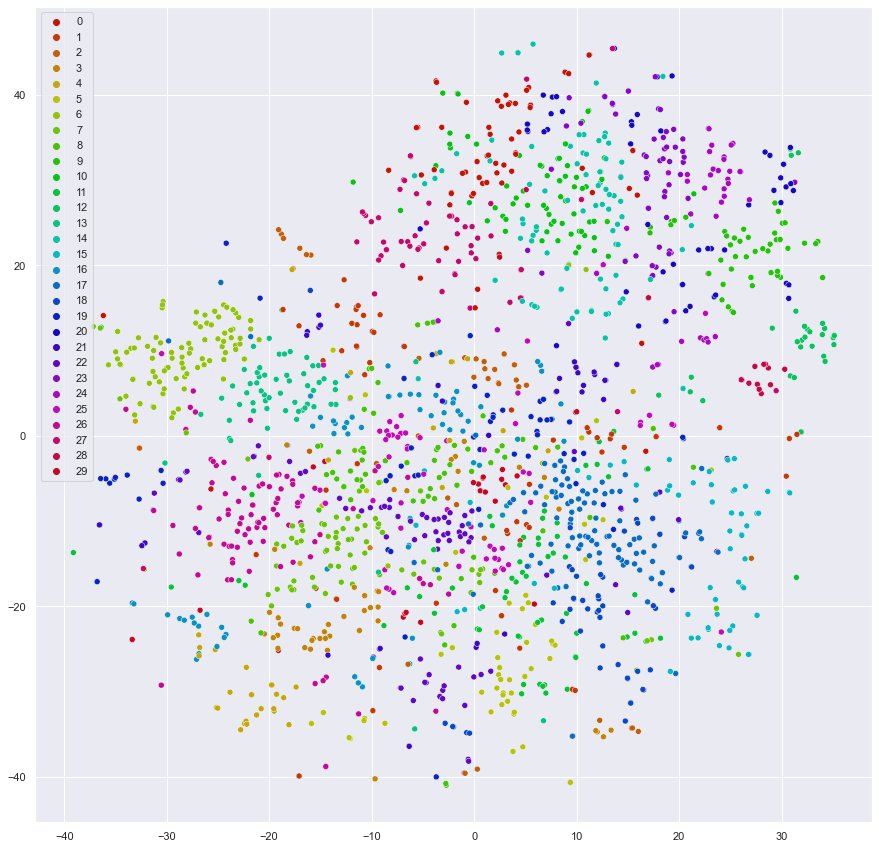

In [333]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(15,15)})

palette = sns.hls_palette(k, l=.4, s=.9)

sns.scatterplot(tsne_results[:,0], tsne_results[:,1], hue=y_pred, palette=palette, legend='full')

In [334]:
#Find nearest neighbours of a term
from scipy.spatial import distance
def findNearestNeighbour(term, vectors):
    term_vec = vectors[term]
    tmp = {k: v for k,v in sorted(vectors.items(), key=lambda item: distance.cosine(term_vec, item[1]))}
    nearest = list({k: tmp[k] for k in list(tmp)[:10]}.keys())

    return nearest



In [335]:
for center in kmeans.cluster_centers_:
    for k,v in vectors.items():
        if(v.all == center.all):
            print(k)

In [336]:
def findNearestNeighbourVec(term_vec, vectors):
    tmp = {k: v for k,v in sorted(vectors.items(), key=lambda item: distance.cosine(term_vec, item[1]))}
    nearest = list({k: tmp[k] for k in list(tmp)[:10]}.keys())

    return nearest

In [337]:
centers = kmeans.cluster_centers_
n = findNearestNeighbourVec(centers[0], vectors)
neighbourTerms2 = pd.DataFrame({n[0]:n[1:]})
for i in range(len(centers)):
    n = findNearestNeighbourVec(centers[i], vectors)
    print(i,n)
    neighbourTerms2[n[0]] = n[1:]

neighbourTerms2

0 ['dynamical', 'dynamics', 'one-dimensional', 'described', 'two-dimensional', 'many-body', 'coupled', 'hamiltonian', 'theory', 'equations']
1 ['algorithm', 'optimal', 'worst-case', 'algorithms', 'guaranteed', 'near-optimal', 'polynomial-time', 'best', 'iteration', 'approximation']
2 ['images', 'image', '3d', 'scene', 'rgb-d', 'video', 'segmentation', 'face', 'scenes', 'object']
3 ['research', 'machine-learning', 'recent-years', 'applications', 'deep-learning', 'increasingly', 'widely', 'researchers', 'interest', 'computer-vision']
4 ['autonomous', 'vehicles', 'robotic', 'autonomous-driving', 'mobile', 'vehicle', 'robots', 'navigation', 'environments', 'real-time']
5 ['policy', 'objective', 'agent', 'optimize', 'reinforcement-learning', 'policies', 'strategy', 'maximize', 'agents', 'reward']
6 ['experimental-results', 'proposed-approach', 'proposed-method', 'benchmark-datasets', 'effectiveness', 'benchmarks', 'outperforms', 'superiority', 'experimental-results-demonstrate', 'state-of-t

,dynamical,algorithm,images,research,autonomous,policy,experimental-results,efficient,needs,star,...,gas,channel,learn,electron,x-ray,address,approach,algebraic,\to,social-media
0,dynamics,optimal,image,machine-learning,vehicles,objective,proposed-approach,implementation,need,stellar,...,molecular,receiver,features,light,spectra,issue,use,lie,0,users
1,one-dimensional,worst-case,3d,recent-years,robotic,agent,proposed-method,enables,help,stars,...,electron,transmission,learned,photon,emission,challenges,based,defined,\bar,social
2,described,algorithms,scene,applications,autonomous-driving,optimize,benchmark-datasets,enable,assist,disk,...,surface,relay,input,resonant,detected,issues,paper,algebra,\gamma,user
3,two-dimensional,guaranteed,rgb-d,deep-learning,mobile,reinforcement-learning,effectiveness,application,effort,galaxy,...,transport,transmit,representation,scattering,absorption,limitations,furthermore,closed,\in,online
4,many-body,near-optimal,video,increasingly,vehicle,policies,benchmarks,approach,understand,young,...,liquid,uplink,representations,excitation,optical,challenge,propose,dimension,b,items
5,coupled,polynomial-time,segmentation,widely,robots,strategy,outperforms,use,facilitate,mass,...,water,transmitter,capture,energy,radio,tackle,present,invariant,p,social-networks
6,hamiltonian,best,face,researchers,navigation,maximize,superiority,techniques,organizations,planet,...,material,mimo,feature,frequency,observations,addressing,framework,smooth,\nu,twitter
7,theory,iteration,scenes,interest,environments,agents,experimental-results-demonstrate,framework,development,accretion,...,plasma,wireless,propose,wave,observed,practical,work,operator,\infty,content
8,equations,approximation,object,computer-vision,real-time,reward,state-of-the-art-methods,implement,developing,halo,...,magnetic,downlink,specifically,radiation,flux,paper,particular,compact,\lambda,recommender-systems


In [338]:
zip_iterator = zip(termDict.keys(), y_pred)

value_clusters = dict(zip_iterator)

In [339]:
clusters = {}
for term in value_clusters.items():
    clusters[term[1]] = []
for term in value_clusters.items():
    clusters[term[1]].append(term[0])

In [340]:
for i in clusters.keys():
    print(i,clusters[i])

26 ['paper', 'process', 'based', 'system', 'systems', 'i.e.', 'network', 'previous', 'framework', 'multiple', 'test', 'models', 'work', 'focus', 'different', 'finally', 'number', 'use', 'provide', 'common', 'propose', 'introduce', 'model', 'demonstrate', 'algorithms', 'tasks', 'furthermore', 'task', 'data', 'sets', 'random', 'algorithm', 'control', 'approach', 'key', 'given', 'set', 'problem', 'best', 'time', 'graph', 'graphs', 'results', 'analysis', 'learning', 'prediction', 'classification', 'detection', 'networks', 'information', 'perform', 'proposed', 'specifically', 'called', 'solution', 'approaches', 'develop', 'types', 'clustering', 'specific', 'context', 'analyze', 'modeling', 'new', 'existing', 'works', 'identify', 'methods', 'method', 'like', 'uses', 'knowledge', 'search', 'novel', 'developed', 'concept', 'problems', 'dynamic', 'real', 'selection', 'available', 'limited', 'evaluate', 'techniques', 'allows', 'evaluation', 'domain', 'able', 'technique', 'important', 'setting']


HDBSCAN Clustering

Number of hits per topic

In [341]:
#Number of word from certain cluster in the abstract
def topicHits(text, value_clusters):
    topics = {}
    wordDict = Counter(text)
    for word in wordDict.keys():
        if(word in value_clusters.keys()):
            topics[value_clusters[word]] = wordDict[word]
    return topics

In [342]:
#Just return which topics were hit
def pureTopics(topics):
    return topics.keys()

In [343]:
df_combined['topic_hits'] = df_combined.doubleFilteredAbstracts.apply(topicHits, value_clusters=value_clusters)
df_combined['topics'] = df_combined.topic_hits.apply(pureTopics)
df_combined

,abstract,list_categories,main_categories,year,filteredAbstracts,doubleFilteredAbstracts,topic_hits,topics
948505,This paper studies the impact of a transmitt...,"[cs.IT, math.IT]","[cs, math]",2018,"[paper, studies, impact, transmitter, molecule...","[paper, impact, transmitter, generation, proce...","{26: 1, 13: 1, 21: 1, 7: 2, 20: 4, 16: 1, 1: 1...","(26, 13, 21, 7, 20, 16, 1, 8, 23, 10, 4, 22)"
1497027,Deep Reinforcement Learning (DRL) is conside...,"[cs.LG, cs.AI]",[cs],2021,"[deep-reinforcement-learning, drl, considered,...","[deep-reinforcement-learning, framework, impro...","{11: 1, 26: 1, 13: 1, 6: 1, 4: 1, 3: 1, 19: 1,...","(11, 26, 13, 6, 4, 3, 19, 10, 16, 8, 25, 5, 29)"
1040347,Ad and tracking blocking extensions are popu...,[cs.CR],[cs],2018,"[ad, tracking, blocking, extensions, popular, ...","[tracking, popular, tools, improving, web, per...","{4: 1, 3: 1, 7: 1, 13: 1, 29: 3, 16: 1, 19: 2,...","(4, 3, 7, 13, 29, 16, 19, 11, 1, 10, 8, 26, 17)"
1189193,"We introduce a simple, geometric model of op...","[cs.SI, econ.TH]","[cs, econ]",2019,"[introduce, simple, geometric, model, opinion,...","[introduce, model, polarization, model, utiliz...","{26: 1, 23: 3, 17: 1, 29: 1, 10: 1, 25: 1, 7: ...","(26, 23, 17, 29, 10, 25, 7, 21, 13, 5)"
1336457,Computer vision (CV) has achieved great succ...,[cs.CV],[cs],2020,"[computer-vision, cv, achieved, great, success...","[computer-vision, achieved, great, success, se...","{3: 1, 13: 1, 15: 1, 2: 1, 26: 1, 10: 1, 27: 1...","(3, 13, 15, 2, 26, 10, 27, 19, 8, 6, 17, 29, 2..."
...,...,...,...,...,...,...,...,...
1822458,We use the exact instanton expansion to illu...,[hep-th],[hep-th],2004,"[use, exact, instanton, expansion, illustrate,...","[use, expansion, string, gauge, theory, dimens...","{26: 1, 14: 2, 10: 1, 27: 1, 24: 1, 22: 1, 23:...","(26, 14, 10, 27, 24, 22, 23, 0)"
1929984,The serious study of such science fiction st...,"[physics.space-ph, physics.pop-ph]",[physics],2002,"[study, science, fiction, staples, wormholes, ...","[study, science, time, general-relativity]","{10: 1, 3: 1, 26: 1, 14: 1}","(10, 3, 26, 14)"
1891142,We apply the Euler--Maclaurin formula to fin...,"[math.CO, math.NT]",[math],2006,"[apply, euler, --, maclaurin, formula, find, a...","[formula, find, asymptotic, expansion, \log, \...","{27: 1, 10: 1, 14: 1, 12: 2, 26: 1, 7: 1, 13: ...","(27, 10, 14, 12, 26, 7, 13, 24, 22, 3)"
1936483,It is shown that the presence of mixed-cultu...,[physics.bio-ph],[physics],2005,"[shown, presence, mixed-culture, growth, batch...","[presence, batch, data, analysis, singularity,...","{10: 1, 19: 2, 26: 1, 27: 1, 28: 2, 14: 1, 4: ...","(10, 19, 26, 27, 28, 14, 4, 3, 13)"


In [350]:
# Topic hits per year
hits_per_year = {}
for index, row in df_combined.iterrows():
    if(row['year'] in hits_per_year.keys()):
        hits_per_year[row['year']] = Counter(hits_per_year[row['year']]) + Counter(row['topics'])
    else:
        hits_per_year[row['year']] = Counter(row['topics'])
for key in hits_per_year.keys():
    hits_per_year[key] = {k: v for k, v in sorted(dict(hits_per_year[key]).items(), key=lambda item: item[1], reverse=True)}

hits_per_year

{'2018': {26: 1726,
  10: 1429,
  7: 1272,
  13: 1182,
  22: 1098,
  6: 887,
  25: 863,
  3: 832,
  19: 656,
  11: 654,
  1: 645,
  8: 640,
  27: 618,
  16: 604,
  5: 543,
  0: 506,
  14: 504,
  18: 492,
  2: 478,
  23: 467,
  17: 453,
  15: 414,
  4: 398,
  24: 371,
  20: 344,
  21: 306,
  29: 304,
  9: 303,
  12: 163,
  28: 114},
 '2021': {26: 2106,
  10: 1709,
  7: 1668,
  13: 1568,
  22: 1472,
  6: 1322,
  25: 1176,
  3: 1127,
  19: 921,
  8: 914,
  11: 861,
  18: 823,
  1: 793,
  16: 769,
  5: 740,
  17: 712,
  2: 686,
  27: 619,
  0: 580,
  14: 574,
  15: 565,
  23: 550,
  4: 506,
  29: 410,
  21: 396,
  20: 383,
  24: 373,
  9: 335,
  12: 199,
  28: 118},
 '2019': {26: 1997,
  10: 1629,
  7: 1468,
  13: 1407,
  22: 1288,
  6: 1085,
  25: 986,
  3: 968,
  19: 786,
  11: 776,
  8: 752,
  1: 736,
  16: 679,
  27: 673,
  18: 653,
  2: 608,
  5: 607,
  0: 581,
  17: 569,
  14: 553,
  23: 509,
  4: 493,
  15: 468,
  20: 414,
  21: 409,
  24: 392,
  9: 347,
  29: 315,
  12: 217,
  28: 

In [354]:
hits_per_year = {k: v for k, v in sorted(hits_per_year.items(), key=lambda item: item[0], reverse=True)}
hits_per_year

{'2021': {26: 2106,
  10: 1709,
  7: 1668,
  13: 1568,
  22: 1472,
  6: 1322,
  25: 1176,
  3: 1127,
  19: 921,
  8: 914,
  11: 861,
  18: 823,
  1: 793,
  16: 769,
  5: 740,
  17: 712,
  2: 686,
  27: 619,
  0: 580,
  14: 574,
  15: 565,
  23: 550,
  4: 506,
  29: 410,
  21: 396,
  20: 383,
  24: 373,
  9: 335,
  12: 199,
  28: 118},
 '2020': {26: 2487,
  10: 2039,
  7: 1897,
  13: 1751,
  22: 1702,
  6: 1419,
  25: 1319,
  3: 1278,
  19: 1072,
  8: 1012,
  11: 986,
  1: 947,
  16: 888,
  18: 854,
  5: 843,
  27: 841,
  0: 777,
  2: 775,
  17: 738,
  14: 706,
  23: 650,
  4: 646,
  15: 617,
  20: 534,
  24: 519,
  21: 471,
  29: 446,
  9: 440,
  12: 254,
  28: 158},
 '2019': {26: 1997,
  10: 1629,
  7: 1468,
  13: 1407,
  22: 1288,
  6: 1085,
  25: 986,
  3: 968,
  19: 786,
  11: 776,
  8: 752,
  1: 736,
  16: 679,
  27: 673,
  18: 653,
  2: 608,
  5: 607,
  0: 581,
  17: 569,
  14: 553,
  23: 509,
  4: 493,
  15: 468,
  20: 414,
  21: 409,
  24: 392,
  9: 347,
  29: 315,
  12: 217,
 

In [427]:
#Plotting
# 2021: {26: 2100}
# x axis: 2021, y axis: 2100, line: 26
def plottingParams(hits_per_year):
    k = len(set(y_pred))
    yrs = len(set(hits_per_year.keys()))
    min_yr = int(min(set(hits_per_year.keys())))
    list_years = list(hits_per_year.keys())
    list_years.reverse()
    x_plotting = [list_years]*k
    y_plotting = np.zeros((k,yrs))
    for year in hits_per_year.keys():
        for line in hits_per_year[year].keys():
            y_plotting[line][int(year)-min_yr] = hits_per_year[year][line]
    return x_plotting, y_plotting

In [431]:
x_plotting, y_plotting = plottingParams(hits_per_year)
print(x_plotting[1])

['1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']


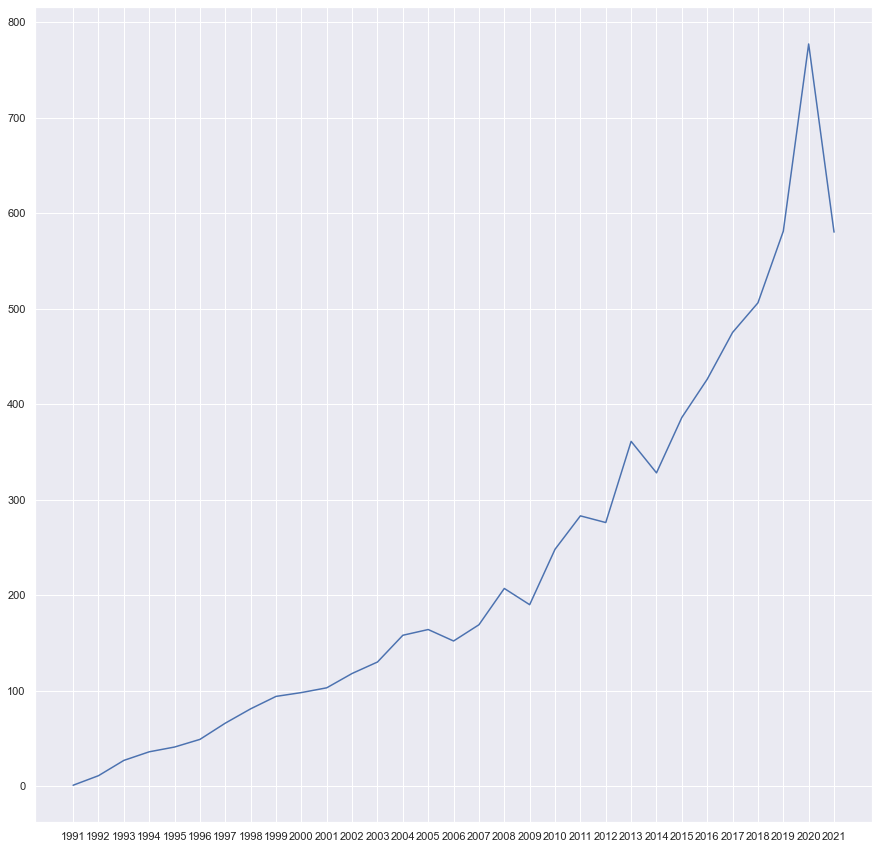

In [432]:
plt.plot(x_plotting[0], y_plotting[0])

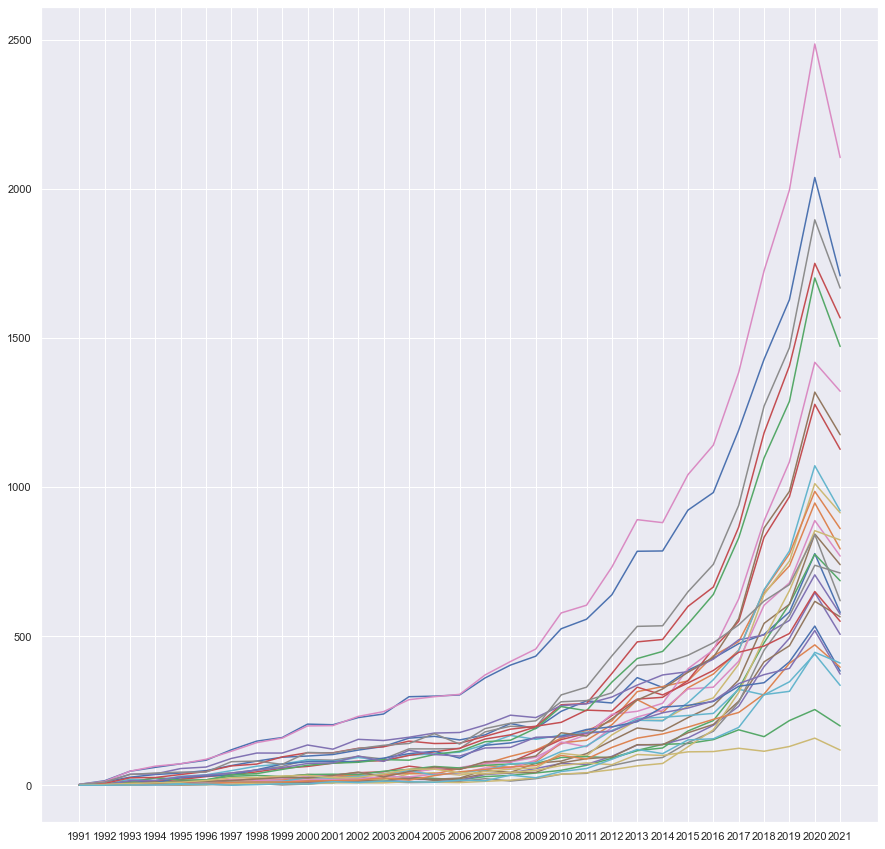

In [433]:
for i in range(k):
    plt.plot(x_plotting[i], y_plotting[i])

Normalize topics over time

In [434]:
hits_normalized = {}
for year in hits_per_year.keys():
    total = 0
    hits_normalized[int(year)] = {}
    for key in hits_per_year[year].keys():
        total += hits_per_year[year][key]
    for key in hits_per_year[year].keys():
        hits_normalized[int(year)][key] = hits_per_year[year][key]/total

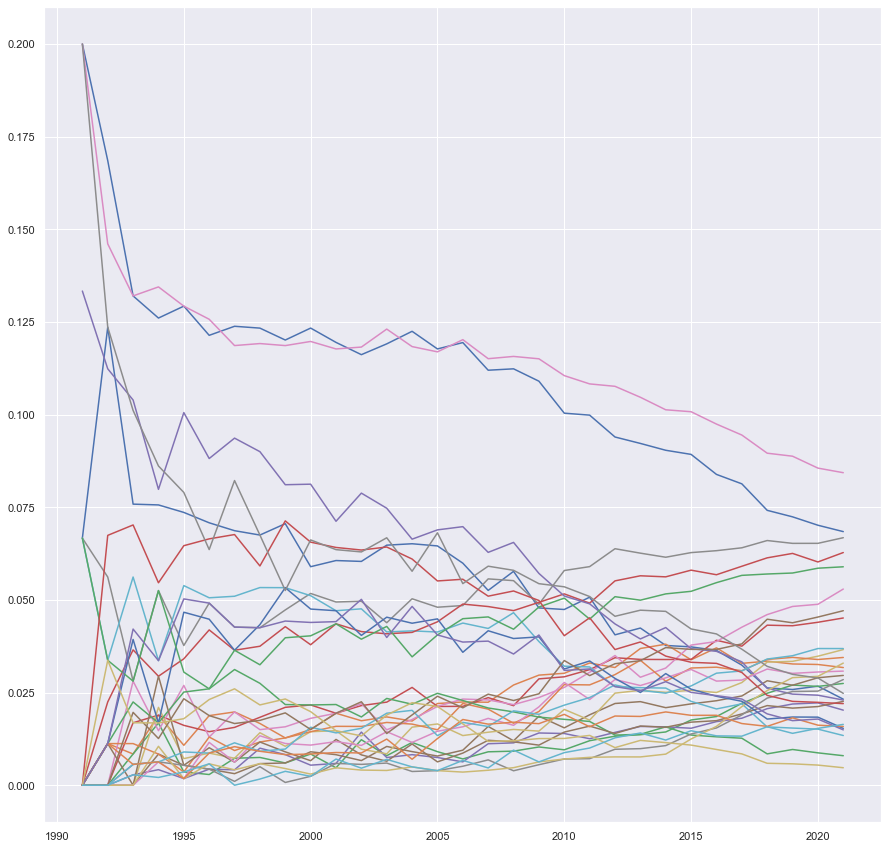

In [435]:
x_p, y_p = plottingParams(hits_normalized)
for i in range(k):
    plt.plot(x_p[i], y_p[i])